In [0]:
pip install pydicom

     |████████████████████████████████| 35.5MB 89kB/s 


In [0]:
pip install tensorboardX

     |████████████████████████████████| 204kB 4.7MB/s 


Mount Drive

In [0]:
from google.colab import drive
drive.flush_and_unmount()


Drive not mounted, so nothing to flush and unmount.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path ='/content/drive/My Drive/Main Project Dataset/'

Load Data

In [0]:
import numpy as np
import h5py
import scipy.io as sio
from tensorflow import keras
from skimage.io import imread

class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, data_dir, batch_size = 32, x_dim=(512,512,1), y_dim=(512,512,1), shuffle=True):
        self.list_IDs = list_IDs
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.list_IDs)/self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_IDs = [self.list_IDs[k] for k in batch_indexes]
        
        X, Y = self.__batch_data_generation(batch_IDs)
        
        return X,Y
    
    def __batch_data_generation(self, batch_IDs):
        X = np.empty((self.batch_size, *self.x_dim)) #* is used to unpack the self.dim tuple
        Y = np.empty((self.batch_size, *self.y_dim))
        
        for i, ID in enumerate(batch_IDs):
            X[i,:], Y[i,:] = self.load_mat(ID, 'new_sino', 'sino')
            
        return X,Y
    
    def load_mat(self, ID, x_name, y_name):
        file_name = self.data_dir+'Metal Deleted Sinogram/' + str(ID) + '.mat'
        try:
            with h5py.File(file_name, 'r') as f:
                x = np.reshape(f[x_name], self.x_dim)
        except OSError:
            f = sio.loadmat(file_name)
            x = np.reshape(f[x_name], self.x_dim)
        file_name = self.data_dir+'True Sinogram/' + str(ID) + '.mat'
        try:
            with h5py.File(file_name, 'r') as f:
                y = np.reshape(f[y_name], self.y_dim)
        except OSError:
            f = sio.loadmat(file_name)
            y = np.reshape(f[y_name], self.y_dim)
                    
        #sart=imread(self.data_dir+'/SART/Sparse100/'+str(ID)+'.png',0)
        #x = np.reshape(sart, self.y_dim)
        return x,y

if __name__ == '__main__':
    generator = DataGenerator(list(np.arange(0, 13)), path)
    #x,y = generator.load_mat(5, 'new_sino', 'sino')
    #print(x.shape,y.shape)

In [0]:
import numpy as np
from tensorflow import keras
import tensorflow as tf 

In [0]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = keras.Sequential()
    result.add(keras.layers.Conv2D(filters, size, strides=2, padding='same',
                              kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
      result.add(keras.layers.BatchNormalization())
    result.add(keras.layers.LeakyReLU())

    return result

In [0]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = keras.Sequential()
    result.add(keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    result.add(keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(keras.layers.Dropout(0.5))
    result.add(keras.layers.ReLU())

    return result

U-Net


In [0]:
def UNet():
    inputs = keras.layers.Input(shape=(512,512,1))
    
    #level 1
    conv64_1 = keras.layers.Conv2D(64, [3,3], [1,1], 'same', activation = 'relu')(inputs)
    conv64_1_BN = keras.layers.BatchNormalization()(conv64_1)
    conv64_2 = keras.layers.Conv2D(64, [3,3], [1,1], 'same', activation = 'relu')(conv64_1_BN)
    conv64_2_BN = keras.layers.BatchNormalization()(conv64_2)
    conv64_3 = keras.layers.Conv2D(64, [3,3], [1,1], 'same', activation = 'relu')(conv64_2_BN)
    conv64_3_BN = keras.layers.BatchNormalization()(conv64_3)
    
    #downsampling to level 2
    conv64_3_pool = keras.layers.MaxPool2D([2,2], padding = 'valid')(conv64_3_BN)
    conv128_1 = keras.layers.Conv2D(128, [3,3], [1,1], 'same', activation = 'relu')(conv64_3_pool)
    conv128_1_BN = keras.layers.BatchNormalization()(conv128_1)
    conv128_2 = keras.layers.Conv2D(128, [3,3], [1,1], 'same', activation = 'relu')(conv128_1_BN)
    conv128_2_BN = keras.layers.BatchNormalization()(conv128_2)
    
    #downsampling to level 3
    conv128_2_pool = keras.layers.MaxPool2D([2,2], padding = 'valid')(conv128_2_BN)
    conv256_1 = keras.layers.Conv2D(256, [3,3], [1,1], 'same', activation = 'relu')(conv128_2_pool)
    conv256_1_BN = keras.layers.BatchNormalization()(conv256_1)
    conv256_2 = keras.layers.Conv2D(256, [3,3], [1,1], 'same', activation = 'relu')(conv256_1_BN)
    conv256_2_BN = keras.layers.BatchNormalization()(conv256_2)
    
    #downsampling to level 4
    conv256_2_pool = keras.layers.MaxPool2D([2,2], padding = 'valid')(conv256_2_BN)
    conv512_1 = keras.layers.Conv2D(512, [3,3], [1,1], 'same', activation = 'relu')(conv256_2_pool)
    conv512_1_BN = keras.layers.BatchNormalization()(conv512_1)
    conv512_2 = keras.layers.Conv2D(512, [3,3], [1,1], 'same', activation = 'relu')(conv512_1_BN)
    conv512_2_BN = keras.layers.BatchNormalization()(conv512_2)
    
    #downsampling to level 5
    conv512_2_pool = keras.layers.MaxPool2D([2,2], padding = 'valid')(conv512_2_BN)
    conv1024_1 = keras.layers.Conv2D(1024, [3,3], [1,1], 'same', activation = 'relu')(conv512_2_pool)
    conv1024_1_BN = keras.layers.BatchNormalization()(conv1024_1)
    conv1024_2 = keras.layers.Conv2D(1024, [3,3], [1,1], 'same', activation = 'relu')(conv1024_1_BN)
    conv1024_2_BN = keras.layers.BatchNormalization()(conv1024_2)
    
    #upsampling to level 4
    level4_ini = keras.layers.Conv2D(512, [3,3], [1,1], 'same', activation='relu')(keras.layers.UpSampling2D((2,2))(conv1024_2_BN))
    level4_ini_concat = keras.layers.concatenate([conv512_2_BN, level4_ini], axis = -1)
    conv512_1_up = keras.layers.Conv2D(512, [3,3], [1,1], 'same', activation = 'relu')(level4_ini_concat)
    conv512_1_BN_up = keras.layers.BatchNormalization()(conv512_1_up)
    conv512_2_up = keras.layers.Conv2D(512, [3,3], [1,1], 'same', activation = 'relu')(conv512_1_BN_up)
    conv512_2_BN_up = keras.layers.BatchNormalization()(conv512_2_up)
    
    #upsampling to level 3
    level3_ini = keras.layers.Conv2D(256, [3,3], [1,1], 'same', activation='relu')(keras.layers.UpSampling2D((2,2))(conv512_2_BN_up))
    level3_ini_concat = keras.layers.concatenate([conv256_2_BN, level3_ini], axis = -1)
    conv256_1_up = keras.layers.Conv2D(256, [3,3], [1,1], 'same', activation = 'relu')(level3_ini_concat)
    conv256_1_BN_up = keras.layers.BatchNormalization()(conv256_1_up)
    conv256_2_up = keras.layers.Conv2D(256, [3,3], [1,1], 'same', activation = 'relu')(conv256_1_BN_up)
    conv256_2_BN_up = keras.layers.BatchNormalization()(conv256_2_up)
    
    #upsampling to level 2
    level2_ini = keras.layers.Conv2D(128, [3,3], [1,1], 'same', activation='relu')(keras.layers.UpSampling2D((2,2))(conv256_2_BN_up))
    level2_ini_concat = keras.layers.concatenate([conv128_2_BN, level2_ini], axis = -1)
    conv128_1_up = keras.layers.Conv2D(128, [3,3], [1,1], 'same', activation = 'relu')(level2_ini_concat)
    conv128_1_BN_up = keras.layers.BatchNormalization()(conv128_1_up)
    conv128_2_up = keras.layers.Conv2D(128, [3,3], [1,1], 'same', activation = 'relu')(conv128_1_BN_up)
    conv128_2_BN_up = keras.layers.BatchNormalization()(conv128_2_up)
    
    #upsampling to level 1
    level1_ini = keras.layers.Conv2D(64, [3,3], [1,1], 'same', activation='relu')(keras.layers.UpSampling2D((2,2))(conv128_2_BN_up))
    level1_ini_concat = keras.layers.concatenate([conv64_3_BN, level1_ini], axis = -1)
    conv64_1_up = keras.layers.Conv2D(64, [3,3], [1,1], 'same', activation = 'relu')(level1_ini_concat)
    conv64_1_BN_up = keras.layers.BatchNormalization()(conv64_1_up)
    conv64_2_up = keras.layers.Conv2D(64, [3,3], [1,1], 'same', activation = 'relu')(conv64_1_BN_up)
    conv64_2_BN_up = keras.layers.BatchNormalization()(conv64_2_up)
    conv1_up = keras.layers.Conv2D(1, [1,1], [1,1], 'same')(conv64_2_BN_up)
    outputs = keras.layers.add([inputs, conv1_up])
    
    
    ###################################################################################
    model = keras.models.Model(inputs = inputs, outputs = outputs)
    #if pretrained_weights:
     #  generator.load_weights(pretrained_weights)
    
    return model
    
UNet().summary()

#if __name__ == '__main__':
#    model = UNet((512,512,1))
#    #model.summary()
#    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy')#, metrics = ['accuracy'])
#    x = np.random.random((1,512,512,1))
#    final_out = model.predict(x)
#    print(np.shape(final_out))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

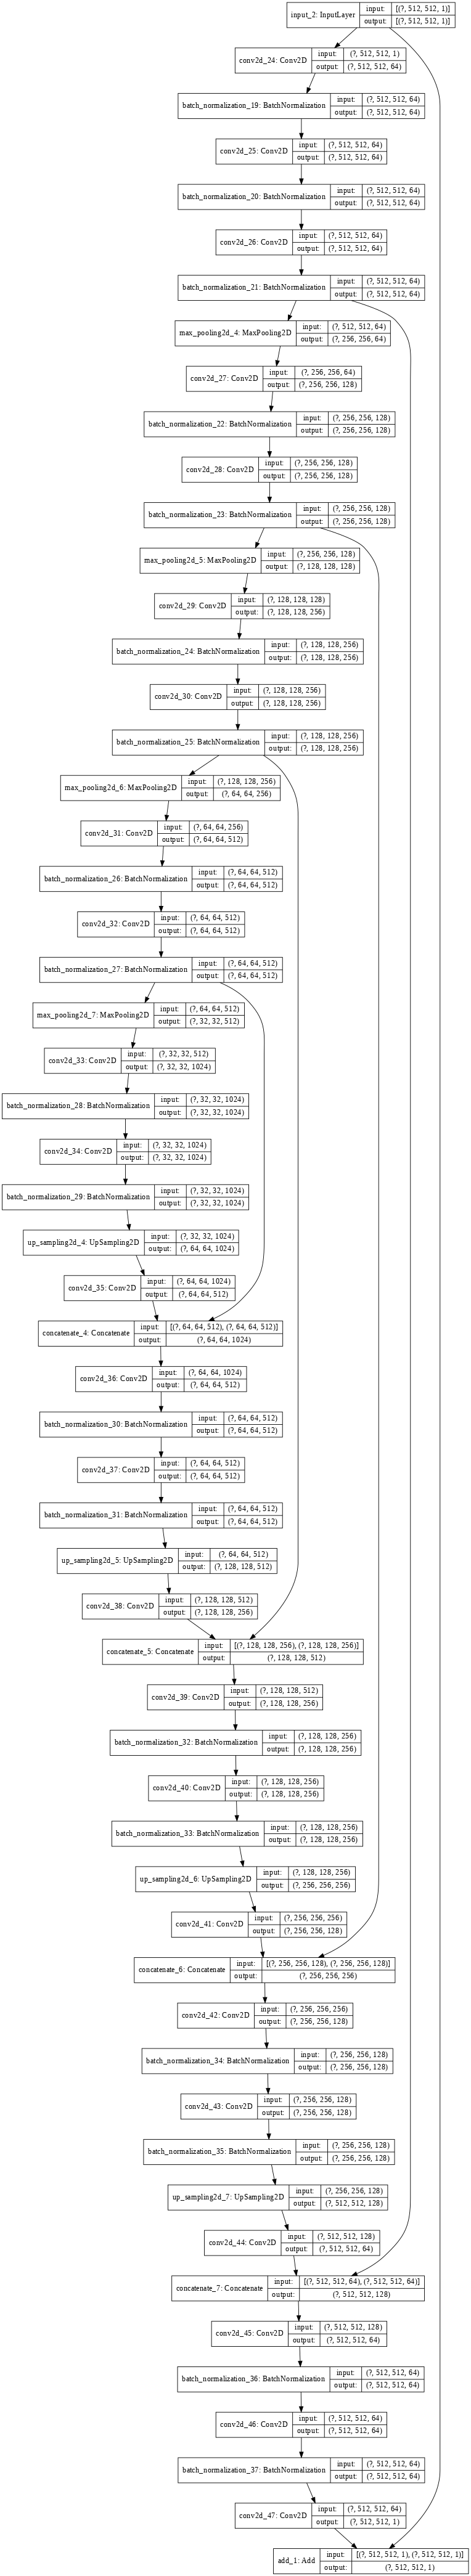

In [0]:
generator = UNet()
keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [0]:
LAMBDA = 10
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [0]:
def Discriminator():
    inp = keras.layers.Input(shape=(512,512,1), name='input_image')
    tar = keras.layers.Input(shape=(512,512,1), name='target_image')

    inputs = keras.layers.Concatenate()([inp, tar])

    #downsampling to level 1
    dlvl1 = downsample(64,4,apply_batchnorm=False)(inputs)
    
    #downsampling to level 2
    dlvl2 = downsample(128,4)(dlvl1)
    
    #downsampling to level 3
    dlvl3 = downsample(256,4)(dlvl2)
    
    #downsampling to level 4
    dlvl4 = downsample(512,4)(dlvl3) 
    
    #downsampling to level 5
    dlvl5 = downsample(512,4)(dlvl4) 

    #downsampling to level 6
    dlvl6 = downsample(512,4)(dlvl5)
    
    #downsampling to level 7
    dlvl7 = downsample(512,4)(dlvl6)
    
    flat1 = keras.layers.Flatten()(dlvl7)
    dense1 = keras.layers.Dense(1, activation='softmax')(flat1)
    # falt1 = keras.layers.Flatten()(conv1024_2_BN)

    model = keras.models.Model(inputs = [inp, tar], outputs = dense1)
    return model

Discriminator().summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 512, 512, 2)  0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential (Sequential)         (None, 256, 256, 64) 2048        concatenate_8[0][0]        

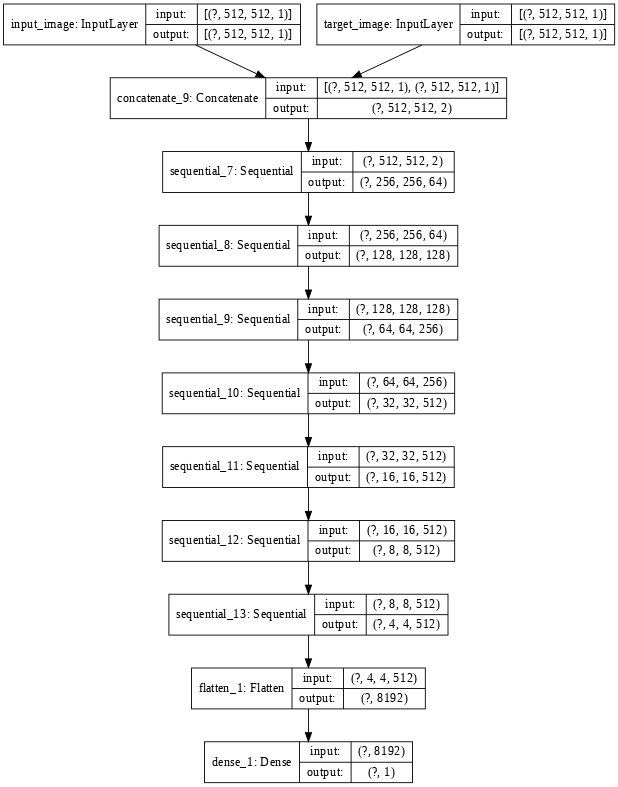

In [0]:
discriminator = Discriminator()
keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [0]:
loss_object = keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [0]:
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.9,beta_2=0.999)
discriminator_optimizer = keras.optimizers.Adam(0.0002, beta_1=0.9)

Plotting Metrics and Loss

In [0]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        #self.acc = []
        #self.val_acc = []
        self.ssim=[]
        self.psnr=[]
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.ssim.append(logs.get('ssim_loss'))
        self.psnr.append(logs.get('psnr'))
        #self.acc.append(logs.get('acc'))
        #self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(16,8), sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.set_ylabel('MSE')
        ax1.set_xlabel('Epoch')
        ax1.legend()
        
        ax2.plot(self.x, self.ssim, label="ssim")
        ax2.set_ylabel('SSIM')
        ax2.set_xlabel('Epoch')
        ax2.legend()
        
        ax3.plot(self.x, self.psnr, label="psnr")
        ax3.set_ylabel('PSNR')
        ax3.set_xlabel('Epoch')
        ax3.legend()
    
        plt.savefig(path+'training.png')
        plt.show()

        
plot = PlotLearning()

Metrics For Evaluation






In [0]:
import tensorflow as tf
from keras import backend

 
# Structural Similarity Index
def ssim_loss(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 255))

# Peak Signal To Noise Ratio
def psnr(y_true, y_pred):
  return tf.reduce_mean(tf.image.psnr(y_true, y_pred, 255))

def msr(y_true, y_pred):
  return tf.reduce_mean(tf.keras.losses.mean_squared_error(y_true,y_pred))


Using TensorFlow backend.


Training with matlab generated shapes




In [0]:

train_IDs = list(np.arange(0,680))
val_IDs = list(np.arange(680, 910))
train_generator = DataGenerator(train_IDs, path, batch_size = 2)
val_generator = DataGenerator(val_IDs, path, batch_size = 2)

#tbCallBack = keras.callbacks.TensorBoard(log_dir = path+'TestTraining/logs', write_graph = True, write_images = True) #Tensorboard callback
#checkpoint_path = path+'TestTraining/checkpoints/test_cp.ckpt'
#cpCallBack = keras.callbacks.ModelCheckpoint(checkpoint_path) #checkpoints callBack

#model = UNet((512,512,1))
#model.summary()
#model.compile(optimizer = 'rmsprop', loss = 'mean_squared_error', metrics = [ssim_loss,psnr])
#history= model.fit_generator(train_generator, epochs = 100, validation_data = val_generator,
                    #workers = 6, callbacks = [plot])#,tbCallBack, cpCallBack])

In [0]:
#print(train_generator[0][0].astype('float32'))
#print(train_generator[0][1].astype('float32'))
#print(np.shape(train_generator)[0])

In [0]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show() 

In [0]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))

    #with summary_writer.as_default():
    #    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    #    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    #    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    #    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [0]:
import os
import time
from IPython import display
checkpoint_dir = path + 'training_checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()

        display.clear_output(wait=True)

        #for n in range(np.shape(test_ds)[0]):
         #   generate_images(generator, test_ds[n][0].astype('float32'), test_ds[n][1].astype('float32'))
        print("Epoch: ", epoch)

        # Train
        for n in range(np.shape(train_ds)[0]):
          print('.', end='')
          if (n+1) % 100 == 0:
            print()
          train_step(train_ds[n][0].astype('float32'), train_ds[n][1].astype('float32'), epoch)
        print()

        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                          time.time()-start))
    checkpoint.save(file_prefix = checkpoint_prefix)

In [0]:
EPOCHS = 100
fit(train_generator, EPOCHS, val_generator)

Epoch:  8
....................................................................................................
................

Save Model

In [0]:
#generator.save(path+"modelreal1.h5")
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Load Model from Disk

In [0]:
from tensorflow.keras.models import load_model
#dependencies={
#    'ssim_loss':ssim_loss,
#    'psnr':psnr
#}
# load model
generator = load_model(path+'modelnew.h5')

In [0]:
gen=DataGenerator(np.arange(0,1134),path, batch_size = 1)

print("Image    B/w recon and original    b/w predicted and original")

sum=0.0
for i in range(0,72):
  x,y=gen.load_mat(i,'new_sino','sino')
  x=np.reshape(x,[1,512,512,1])
  pre=generator.predict(x)
  with tf.compat.v1.Session() as sess:
    sum+=ssim_loss(tf.convert_to_tensor(pre),tf.convert_to_tensor(y.astype('float32'))).eval()
    print(str(i)+"        "+str(ssim_loss(tf.convert_to_tensor(x),tf.convert_to_tensor(y)).eval())+"           "+str(ssim_loss(tf.convert_to_tensor(pre),tf.convert_to_tensor(y.astype('float32'))).eval()))
print(sum)
print(sum/72)

Image    B/w recon and original    b/w predicted and original
0        0.90323913           0.93987596
1        0.89648193           0.9405367
2        0.8920636           0.9390807
3        0.894071           0.9444159
4        0.8995988           0.94456893
5        0.9216093           0.97902155
6        0.91686344           0.9791053
7        0.915642           0.97882646
8        0.91484785           0.9783409
9        0.9140551           0.97815424
10        0.8910613           0.9777428
11        0.8899206           0.9782985
12        0.92194384           0.98119926
13        0.82740355           0.9395244
14        0.82830834           0.93984175
15        0.8283332           0.93752867
16        0.83650726           0.9405514
17        0.83140457           0.9393002
18        0.8380916           0.9406465
19        0.837938           0.9392733
20        0.8421782           0.92631245
21        0.8436134           0.9276017
22        0.8469615           0.92944247
23        0.

In [0]:
gen=DataGenerator(np.arange(0,1134),path, batch_size = 1)

print("Image    B/w recon and original    b/w predicted and original")
sum=0.0
for i in range(0,72):
  x,y=gen.load_mat(i,'new_sino','sino')
  x=np.reshape(x,[1,512,512,1])
  pre=generator.predict(x)
  with tf.compat.v1.Session() as sess:
    sum+=psnr(pre,y).eval()
    print(str(i)+"        "+str(psnr(x,y).eval())+"           "+str(psnr(pre,y).eval()))
print(sum)
print(sum/72)

Image    B/w recon and original    b/w predicted and original
0        26.566814           32.048386
1        25.62453           32.15125
2        25.250616           32.15001
3        25.549578           32.88427
4        26.046038           32.79869
5        27.019636           39.22687
6        26.403927           39.63643
7        26.355497           39.638775
8        26.287123           39.481586
9        26.222628           38.956867
10        24.586613           39.371857
11        24.372622           39.47645
12        28.144844           40.62552
13        20.921185           30.34825
14        21.126635           30.524233
15        20.971676           29.885265
16        21.306145           29.894781
17        20.822897           29.968185
18        21.332333           30.321085
19        21.29761           30.07363
20        20.197268           28.634064
21        20.330324           29.034138
22        20.619715           29.424519
23        22.123402           29.547909


In [0]:
gen=DataGenerator(np.arange(0,1134),path, batch_size = 1)

print("Image    B/w recon and original    b/w predicted and original")
sum=0.0
for i in range(0,72):
  x,y=gen.load_mat(i,'new_sino','sino')
  x=np.reshape(x,[1,512,512,1])
  pre=generator.predict(x)
  with tf.compat.v1.Session() as sess:
    sum+=msr(pre,y).eval()
    print(str(i)+"        "+str(msr(x,y).eval())+"           "+str(msr(pre,y).eval()))
print(sum)
print(sum/72)

Image    B/w recon and original    b/w predicted and original
0        143.35038836419554           40.57340767571978
1        178.08491074129273           39.623754306009666
2        194.09696198209238           39.635028119145026
3        181.1850879128962           33.4697962927645
4        161.61310622867117           34.135892410732
5        129.15662040886156           7.769497962648203
6        148.82906576246148           7.070296079511009
7        150.49799314841064           7.066473674711145
8        152.88609569531152           7.326921250565273
9        155.17351483009102           8.267869422869579
10        226.16176470853438           7.514402716670514
11        237.58455149054066           7.335591995034444
12        99.67724027204984           5.630257703103366
13        525.9710852232748           60.014390019085845
14        501.6687573497681           57.631114853823924
15        519.8914508568764           66.76577497339555
16        481.3552392744166           66

Evaluation of Model

In [0]:
val_generator = DataGenerator(np.arange(1,11), path+'Original/', batch_size = 1)

print(model.evaluate_generator(val_generator,1))
print(model.metrics_names)



In [0]:

gen=DataGenerator(np.arange(1,11),path, batch_size = 1)

i=1
while(i<11):
  x,y=gen.load_mat(i,'new_sino','sino')
  print(model.evaluate([[x,]],[[y,]]))
  i=i+1

NameError: ignored

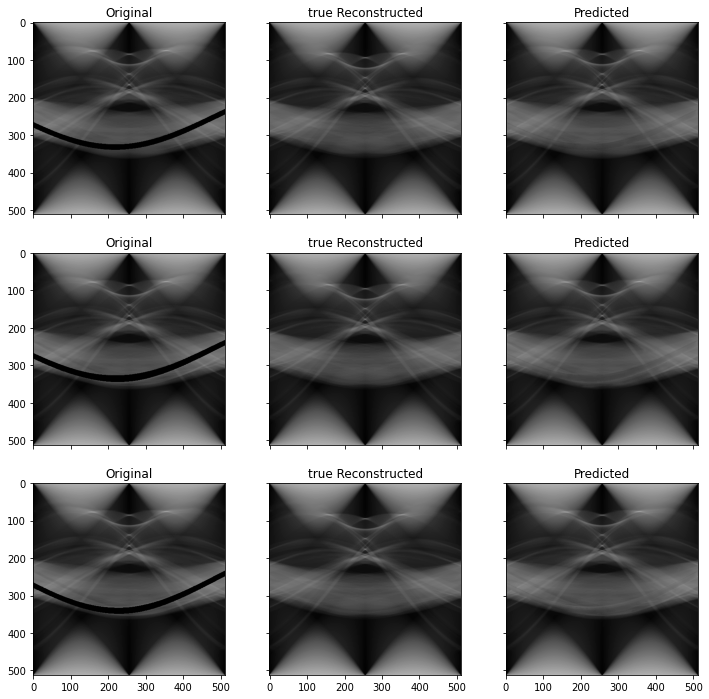

In [0]:
import matplotlib.pyplot as plt

n=3
gen=DataGenerator(np.arange(0,1000),path, batch_size = 1)

fig,ax=plt.subplots(n,3,figsize=(12,12),sharex=True,sharey=True)

i=1
j=1
while(i<n+1):
  gt,hrecon=gen.load_mat(j,'new_sino','sino')
 # gt1,lrecon1=gen.load_mat(i,'GT','LRecon2')
  gt=np.reshape(gt,(1,512,512,1))
  j=j+1
  pre=generator.predict(gt)
  
  
  ax[i-1][0].imshow(np.squeeze(gt), cmap=plt.cm.Greys_r)
  ax[i-1][0].set_title('Original')

  ax[i-1][1].imshow(np.squeeze(hrecon), cmap=plt.cm.Greys_r)
  ax[i-1][1].set_title('true Reconstructed')

  #ax[i-1][2].imshow(np.squeeze(lrecon1), cmap=plt.cm.binary)
  #ax[i-1][2].set_title('SART Sparse Reconstructed')

  ax[i-1][2].imshow(np.squeeze(pre), cmap=plt.cm.Greys_r)
  ax[i-1][2].set_title('Predicted')
  i=i+1


#plt.savefig(path+'FBP/'+'no.png')
plt.show()

Convert back to Image

In [0]:
from skimage.transform import iradon

reconstruction_fbp = iradon(sinogram, theta=theta, circle=True)
error = reconstruction_fbp - image
print(f"FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5),
                               sharex=True, sharey=True)
ax1.set_title("Reconstruction\nFiltered back projection")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
plt.show()

NameError: ignored

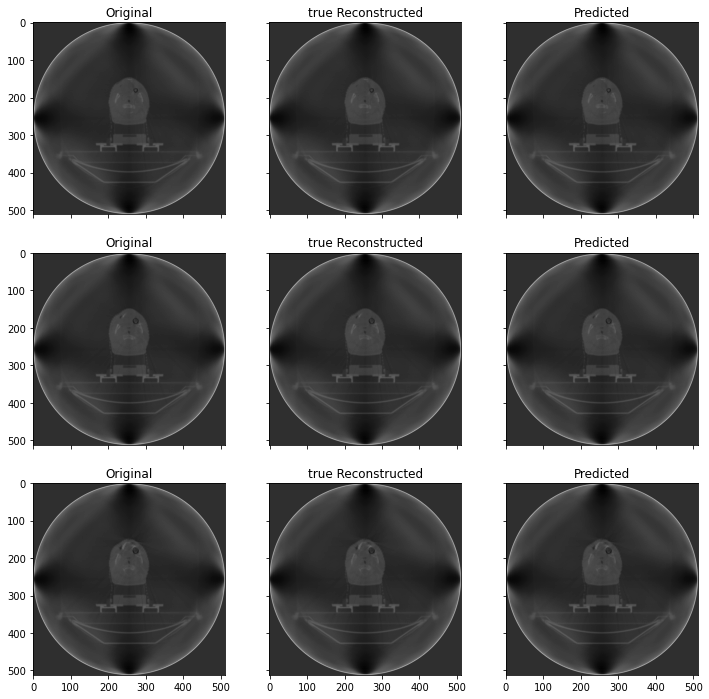

In [0]:
import matplotlib.pyplot as plt
from skimage.transform import iradon
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale,iradon_sart

n=3
gen=DataGenerator(np.arange(0,1000),path, batch_size = 1)

fig,ax=plt.subplots(n,3,figsize=(12,12),sharex=True,sharey=True)
i=1
j=0
while(i<n+1):
  gt,hrecon=gen.load_mat(j,'new_sino','sino')
 # gt1,lrecon1=gen.load_mat(i,'GT','LRecon2')
  gt=np.reshape(gt,(1,512,512,1))
  j=j+1
  pre=generator.predict(gt)
  pre=np.reshape(pre,(512,512))
  #print(np.array(pre).shape)
  theta = np.linspace(0., 180., 512, endpoint=False)
  #reconstruction_fbp = iradon(pre, theta=theta, circle=True)
  pre = pre.astype('double')
  reconstruction_fbp = iradon_sart(pre, theta=theta)

  #ax1.set_title("Reconstruction\nFiltered back projection")
  #ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
  #ax2.set_title("Reconstruction error\nFiltered back projection")
  #ax2.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
  #plt.show()

    
  ax[i-1][0].imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
  ax[i-1][0].set_title('Original')

  ax[i-1][1].imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
  ax[i-1][1].set_title('true Reconstructed')

  #ax[i-1][2].imshow(np.squeeze(lrecon1), cmap=plt.cm.binary)
  #ax[i-1][2].set_title('SART Sparse Reconstructed')

  ax[i-1][2].imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
  ax[i-1][2].set_title('Predicted')
  i=i+1


#plt.savefig(path+'no.png')
plt.show()

In [0]:
import numpy as np
import h5py
import scipy.io as sio
from tensorflow import keras
from skimage.io import imread

class DataGeneratormetal(keras.utils.Sequence):
    def __init__(self, list_IDs, data_dir, batch_size = 32, x_dim=(512,512,1), shuffle=True):
        self.list_IDs = list_IDs
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.x_dim = x_dim
       
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.list_IDs)/self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_IDs = [self.list_IDs[k] for k in batch_indexes]
        
        X= self.__batch_data_generation(batch_IDs)
        
        return X,Y
    
    def __batch_data_generation(self, batch_IDs):
        X = np.empty((self.batch_size, *self.x_dim)) #* is used to unpack the self.dim tuple
       
        
        for i, ID in enumerate(batch_IDs):
            X[i,:]= self.load_mat(ID, 'thresh_sino')
            
        return X
    
    def load_mat(self, ID, x_name):
        file_name = self.data_dir+'Metal Only Sinogram/' + str(ID) + '.mat'
        try:
            with h5py.File(file_name, 'r') as f:
                x = np.reshape(f[x_name], self.x_dim)
        except OSError:
            f = sio.loadmat(file_name)
            x = np.reshape(f[x_name], self.x_dim)

                    
        #sart=imread(self.data_dir+'/SART/Sparse100/'+str(ID)+'.png',0)
        #x = np.reshape(sart, self.y_dim)
        return x

if __name__ == '__main__':
    val = DataGeneratormetal(list(np.arange(0, 13)), path)
    x = val.load_mat(5, 'thresh_sino')
    print(x.shape)

(512, 512, 1)


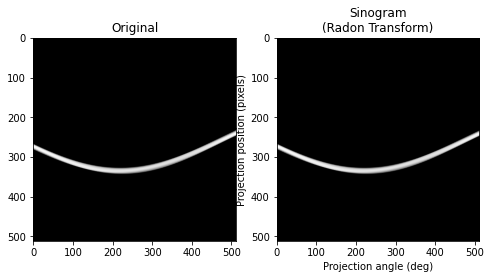

In [0]:
met=DataGeneratormetal(np.arange(0,72),path, batch_size = 1)
metal=met.load_mat(2,"thresh_sino")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(np.squeeze(metal), cmap=plt.cm.Greys_r)
ax2.set_title("Sinogram\n(Radon Transform)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(np.squeeze(metal), cmap=plt.cm.Greys_r)

0


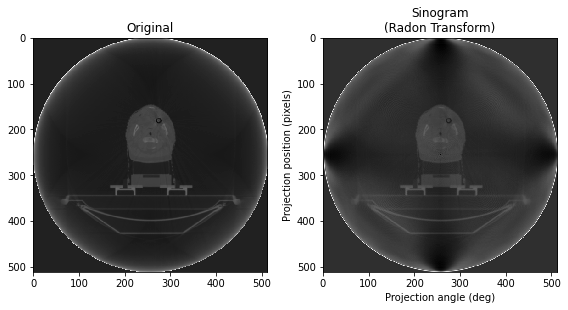

1


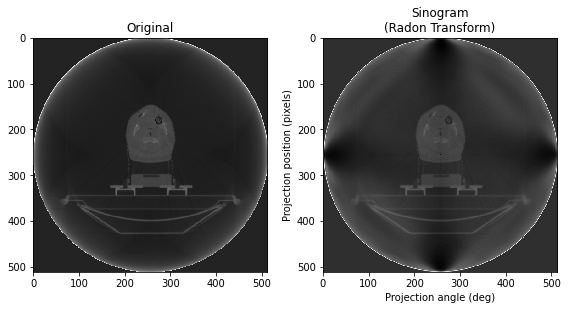

2


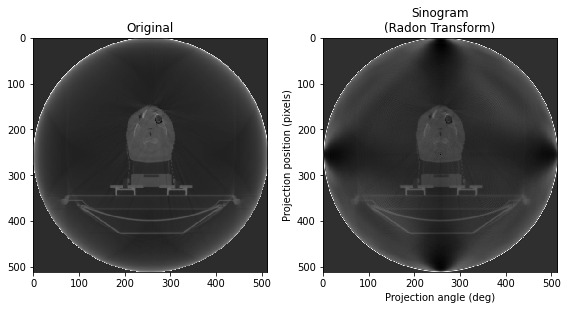

3


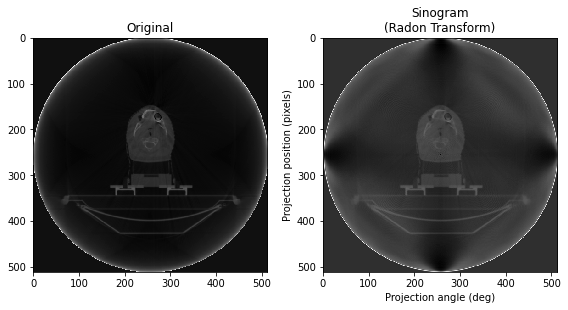

In [0]:
import matplotlib.pyplot as plt
from skimage.transform import iradon
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

n=3
gen=DataGenerator(np.arange(0,304),path, batch_size = 1)


i=0
j=0
while(i<n+1):
  gt,hrecon=gen.load_mat(j,'new_sino','sino')
 # gt1,lrecon1=gen.load_mat(i,'GT','LRecon2')
  gt=np.reshape(gt,(1,512,512,1))
  print(j)
  j=j+1
  pre=generator.predict(gt)
  pre=np.reshape(pre,(512,512))
  #print(np.array(pre).shape)
  theta = np.linspace(0., 180., 512, endpoint=False)
  reconstruction_fbp = iradon(pre, theta=theta, circle=True)
  pre = pre.astype('double')
  reconstruction = iradon_sart(pre, theta=theta)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))
  
  ax1.set_title("Original")
  ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r, interpolation='none')
  ax2.set_title("Sinogram\n(Radon Transform)")
  ax2.set_xlabel("Projection angle (deg)")
  ax2.set_ylabel("Projection position (pixels)")
  ax2.imshow(reconstruction, cmap=plt.cm.Greys_r, interpolation='none')
  fig.tight_layout()
  plt.show()
  i=i+1
  #ax1.set_title("Reconstruction\nFiltered back projection")
  #ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
  #ax2.set_title("Reconstruction error\nFiltered back projection")
  #ax2.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
  #plt.show()

    



#plt.savefig(path+'no.png')
#plt.show()

1


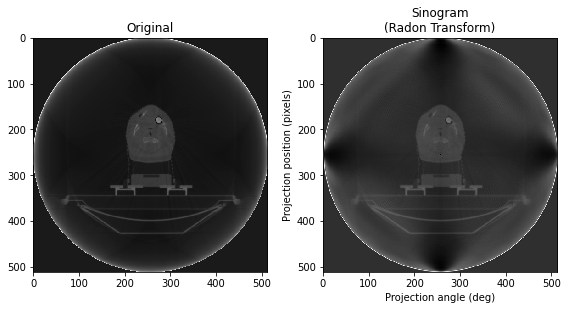

2


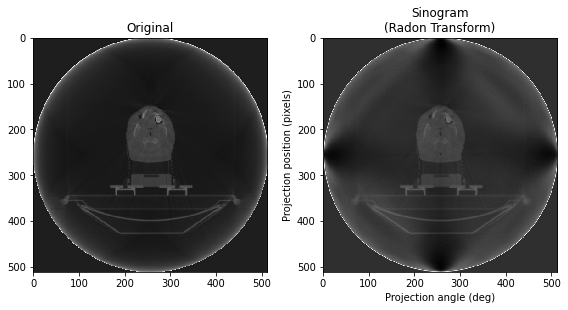

3


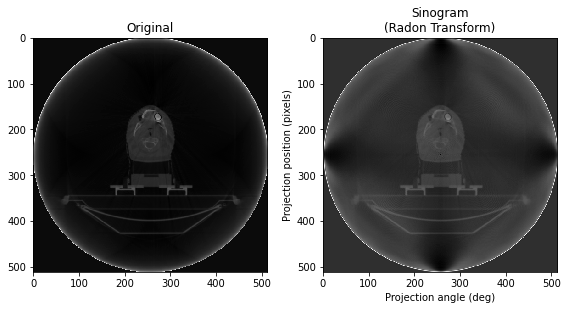

4


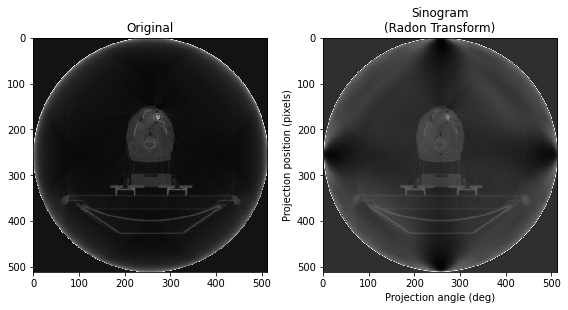

In [0]:
import matplotlib.pyplot as plt
from skimage.transform import iradon
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

n=3
gen=DataGenerator(np.arange(0,1134),path, batch_size = 1)
met=DataGeneratormetal(np.arange(0,72),path, batch_size = 1)

i=0
j=1
while(i<n+1):
  gt,hrecon=gen.load_mat(j,'new_sino','sino')
  metal_sino=met.load_mat(j,'thresh_sino')
 # gt1,lrecon1=gen.load_mat(i,'GT','LRecon2')
  gt=np.reshape(gt,(1,512,512,1))
  print(j)
  j=j+1
  pre=generator.predict(gt)
  pre=pre+metal_sino
  pre=np.reshape(pre,(512,512))
  #print(np.array(pre).shape)
  theta = np.linspace(0., 180., 512, endpoint=False)
  reconstruction_fbp = iradon(pre, theta=theta, circle=True)
  pre = pre.astype('double')
  reconstruction = iradon_sart(pre, theta=theta)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))
  
  ax1.set_title("Original")
  ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r, interpolation='none')
  ax2.set_title("Sinogram\n(Radon Transform)")
  ax2.set_xlabel("Projection angle (deg)")
  ax2.set_ylabel("Projection position (pixels)")
  ax2.imshow(reconstruction, cmap=plt.cm.Greys_r, interpolation='none')
  fig.tight_layout()
  plt.show()
  i=i+1
  #ax1.set_title("Reconstruction\nFiltered back projection")
  #ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
  #ax2.set_title("Reconstruction error\nFiltered back projection")
  #ax2.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
  #plt.show()

    



#plt.savefig(path+'no.png')
#plt.show()